# Cluster Quality: Intrinsic Measures vs. Annotation Results
Does Silhouette Coefficient or Davies-Bouldin give us a good indication of which clusters humans annotated as coherent?

In [1]:
from collections import defaultdict
import itertools
import joblib
import json
from pathlib import Path

import dvc.api
import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from smart_open import open 
import sklearn

import ihop
from ihop.community2vec import GensimCommunity2Vec
import ihop.clustering as ic

sns.set_palette("Dark2")

In [2]:
DATA_PATH = Path("../data")
KMEANS_ANNOTATED_DATA_PATH = DATA_PATH / "kmeans_annotation_task_data"
KMEANS_COHERENCE_CSV = KMEANS_ANNOTATED_DATA_PATH / "Coherence Task March 2022_July 2021 All - both months raw labels.csv"
AGGLOM_ANNOTATED_DATA_PATH = DATA_PATH / "average_agglomerative_annotation_task"
AGGLOM_COHERENCE_CSV = AGGLOM_ANNOTATED_DATA_PATH / "Agglomerative Coherence Task March 2022_July 2021 All - both months raw coherence ratings.csv"
MONTHS = ["2021-07", "2022-03"]

# For kmeans++ models, we're checking out community2vec models from before the 
# user profile fix, so we have to read them directly from DVC, not the data folder.
# The agglomerative models for annotation were produced after that fix.
DVC_C2V_ROOT = "data/community2vec"
DVC_REPO = "../"
KMEANS_GIT_COMMIT ="149c208438c641ca2bd3ee8956bd2e6d2b936e9d"
AGGLOM_GIT_COMMIT = "4d0d46c0b3a509369f051949db0d3fef8ca56ff5"

EXPERIMENT_LIST = [
    ("kmeans", KMEANS_GIT_COMMIT, KMEANS_ANNOTATED_DATA_PATH, KMEANS_COHERENCE_CSV), 
    ("agglomerative", AGGLOM_GIT_COMMIT, AGGLOM_ANNOTATED_DATA_PATH, AGGLOM_COHERENCE_CSV)
]


In [3]:
# Cluster level computation for DB scores, modified from sklearn source
def cluster_davies_bouldin_score(X, labels):
    """Returns the Davies-Bouldin scores for all clusters in a clustering as 
    a dataframe with columns ["cluster_id", "Davies-Bouldin Score"]. This 

    :param X: array-like of shape (n_samples, n_features)
    :param labels: array-like of shape (n_samples, ), predicted labels for each sample
    """
    n_labels = len(set(labels))

    intra_dists = np.zeros(n_labels)
    centroids = np.zeros((n_labels, len(X[0])), dtype=float)
    for k in range(n_labels):
        cluster_k = sklearn.utils._safe_indexing(X, labels == k)
        centroid = cluster_k.mean(axis=0)
        centroids[k] = centroid
        intra_dists[k] = np.average(sklearn.metrics.pairwise_distances(cluster_k, [centroid]))

    centroid_distances = sklearn.metrics.pairwise_distances(centroids)

    if np.allclose(intra_dists, 0) or np.allclose(centroid_distances, 0):
        return 0.0

    centroid_distances[centroid_distances == 0] = np.inf
    combined_intra_dists = intra_dists[:, None] + intra_dists
    scores = np.max(combined_intra_dists / centroid_distances, axis=1)
    return pd.DataFrame(data = {"cluster_id": range(n_labels), "Davies-Bouldin Score":scores})

In [4]:
# Collect the datapoint-level metrics for the different kinds of models
coherence_dfs = []
silhouette_dfs = []
db_scores_dfs = []

for (model_type, git_commit, annotated_data_path, coherence_csv) in EXPERIMENT_LIST:
    subreddit_datapoints = {"month":[], "Model ID":[], "cluster_id":[], "subreddit":[], "Silhouette Coefficient":[], "model_type":[]}

    coherence_df = pd.read_csv(coherence_csv)
    coherence_dfs.append(coherence_df)

    for m in MONTHS:
        c2v_url = dvc.api.get_url(f"{DVC_C2V_ROOT}/RC_{m}/best_model/word2vec.pickle", repo=DVC_REPO, rev=git_commit)
        print("Loading", m, "community2vec model from DVC:", c2v_url)
        c2v_model = gensim.models.Word2Vec.load(c2v_url)
        embeddings = c2v_model.wv.get_normed_vectors()
        subreddit_index = c2v_model.wv.index_to_key
        cluster_model_path = annotated_data_path / f"RC_{m}" / f"{model_type}_model" / "sklearn_cluster_model.joblib"
        cluster_model = joblib.load(cluster_model_path)

        silhouette_scores = sklearn.metrics.cluster.silhouette_samples(embeddings, cluster_model.labels_)
        subreddit_datapoints["month"].extend([m] * len(subreddit_index))
        subreddit_datapoints["Model ID"].extend([f"{m}_{model_type}_clusters"] * len(subreddit_index))
        subreddit_datapoints["cluster_id"].extend(cluster_model.labels_)
        subreddit_datapoints["subreddit"].extend(subreddit_index)
        subreddit_datapoints["Silhouette Coefficient"].extend(silhouette_scores)
        subreddit_datapoints["model_type"].extend([model_type] * len(subreddit_index))

        # Cluster-level DB scores
        tmp_db_scores_df = cluster_davies_bouldin_score(embeddings, cluster_model.labels_)
        tmp_db_scores_df["month"] = m
        tmp_db_scores_df["Model ID"] = f"{m}_{model_type}_clusters"
        tmp_db_scores_df["model_type"] = model_type
        db_scores_dfs.append(tmp_db_scores_df)

    silhouette_dfs.append(pd.DataFrame(data=subreddit_datapoints))

coherence_df = pd.concat(coherence_dfs, ignore_index=True)
silhouette_df = pd.concat(silhouette_dfs, ignore_index=True)
db_scores_df = pd.concat(db_scores_dfs, ignore_index=True)



Loading 2021-07 community2vec model from DVC: s3://ihopmeag/redditdvccache/b0/7a1b7ed92770b861fa31de093547d7
Loading 2022-03 community2vec model from DVC: s3://ihopmeag/redditdvccache/d1/14cf04e2c4af3df6d98a6b72208289
Loading 2021-07 community2vec model from DVC: s3://ihopmeag/redditdvccache/33/de6ad49a48b8691ccfabffae214fac
Loading 2022-03 community2vec model from DVC: s3://ihopmeag/redditdvccache/73/339c9fe05bc164ef502612f55c6ca8


In [5]:
print("Coherence DF shape:", coherence_df.shape)
print("Davies-Bouldin DF shape:", db_scores_df.shape)
print("Silhouette DF shape:", silhouette_df.shape)

Coherence DF shape: (400, 5)
Davies-Bouldin DF shape: (400, 5)
Silhouette DF shape: (40000, 6)


In [6]:
print(silhouette_df.shape)
display(silhouette_df.sort_values(by="Silhouette Coefficient", ascending=False))

(40000, 6)


,month,Model ID,cluster_id,subreddit,Silhouette Coefficient,model_type
33166,2022-03,2022-03_agglomerative_clusters,64,BotTown2,0.485969,agglomerative
34712,2022-03,2022-03_agglomerative_clusters,64,xrptrader,0.467434,agglomerative
37108,2022-03,2022-03_agglomerative_clusters,64,OzBargainNew,0.466233,agglomerative
31586,2022-03,2022-03_agglomerative_clusters,64,SubredditSummaryBot,0.432775,agglomerative
26083,2021-07,2021-07_agglomerative_clusters,97,OzBargainNew,0.425345,agglomerative
...,...,...,...,...,...,...
21833,2021-07,2021-07_agglomerative_clusters,6,hingeapp,-0.251849,agglomerative
36293,2022-03,2022-03_agglomerative_clusters,96,Yankee_Clickers,-0.280684,agglomerative
20107,2021-07,2021-07_agglomerative_clusters,6,Tinder,-0.283284,agglomerative
24776,2021-07,2021-07_agglomerative_clusters,47,aforismiecitazioni,-0.312714,agglomerative


<AxesSubplot:xlabel='Silhouette Coefficient', ylabel='Count'>

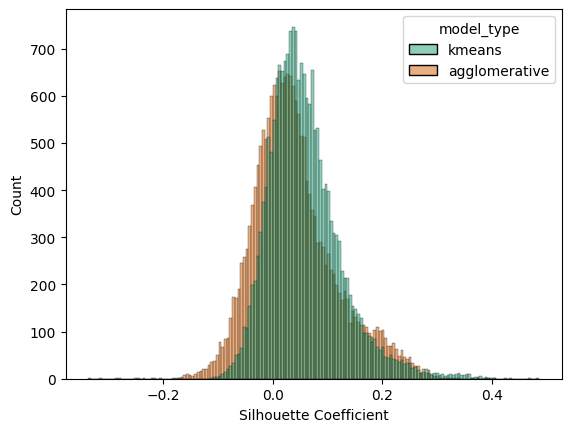

In [7]:
sns.histplot(data=silhouette_df, x="Silhouette Coefficient", hue="model_type")

In [8]:
# Get cluster level Silhouette and DB for each model
cluster_metrics_df = silhouette_df.groupby(by=["Model ID", "cluster_id"])["Silhouette Coefficient"].mean().reset_index()

cluster_metrics_df = pd.merge(cluster_metrics_df, db_scores_df, on=["Model ID", "cluster_id"])

display(cluster_metrics_df)

,Model ID,cluster_id,Silhouette Coefficient,Davies-Bouldin Score,month,model_type
0,2021-07_agglomerative_clusters,0,0.010082,3.194793,2021-07,agglomerative
1,2021-07_agglomerative_clusters,1,0.020041,3.928764,2021-07,agglomerative
2,2021-07_agglomerative_clusters,2,0.082466,3.035783,2021-07,agglomerative
3,2021-07_agglomerative_clusters,3,0.024462,3.455548,2021-07,agglomerative
4,2021-07_agglomerative_clusters,4,0.018234,3.579443,2021-07,agglomerative
...,...,...,...,...,...,...
395,2022-03_kmeans_clusters,95,0.033188,3.405906,2022-03,kmeans
396,2022-03_kmeans_clusters,96,0.034214,3.418205,2022-03,kmeans
397,2022-03_kmeans_clusters,97,0.012300,3.321746,2022-03,kmeans
398,2022-03_kmeans_clusters,98,0.107910,2.624617,2022-03,kmeans


<AxesSubplot:xlabel='Silhouette Coefficient', ylabel='Model ID'>

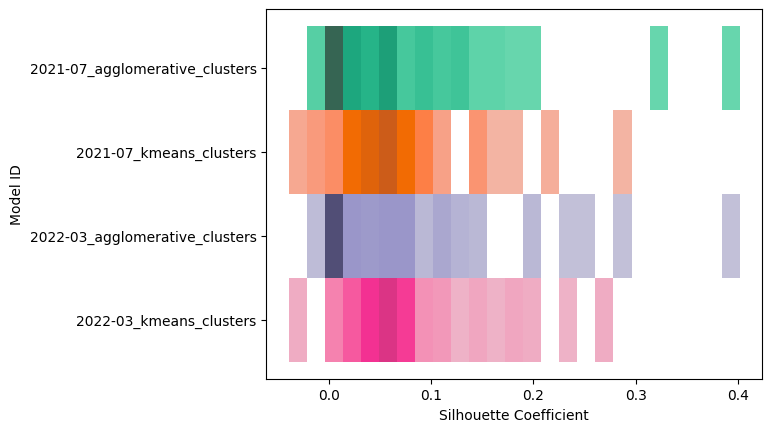

In [9]:
sns.histplot(data=cluster_metrics_df, x="Silhouette Coefficient", y="Model ID", hue="Model ID", legend=False)

In [10]:
coherence_df["Coherence Score"] = coherence_df['Ryan Coherence'] + coherence_df['Rebecca Coherence'] + coherence_df['Ethan Coherence']
coherence_df["Model Precision"] = coherence_df["Coherence Score"] / 3
print(coherence_df.shape)
display(coherence_df)

(400, 7)


,Model ID,Cluster ID,Ryan Coherence,Rebecca Coherence,Ethan Coherence,Coherence Score,Model Precision
0,2021-07_kmeans_clusters,0,1,1,1,3,1.000000
1,2021-07_kmeans_clusters,1,1,1,1,3,1.000000
2,2021-07_kmeans_clusters,2,1,1,0,2,0.666667
3,2021-07_kmeans_clusters,3,0,1,0,1,0.333333
4,2021-07_kmeans_clusters,4,1,1,0,2,0.666667
...,...,...,...,...,...,...,...
395,2021-07_agglomerative_clusters,95,1,0,0,1,0.333333
396,2021-07_agglomerative_clusters,96,1,1,1,3,1.000000
397,2021-07_agglomerative_clusters,97,0,0,0,0,0.000000
398,2021-07_agglomerative_clusters,98,1,1,1,3,1.000000


In [11]:
joined_df = pd.merge(coherence_df, cluster_metrics_df, how="left", left_on=["Model ID", "Cluster ID"], right_on=["Model ID", "cluster_id"])
display(joined_df)

,Model ID,Cluster ID,Ryan Coherence,Rebecca Coherence,Ethan Coherence,Coherence Score,Model Precision,cluster_id,Silhouette Coefficient,Davies-Bouldin Score,month,model_type
0,2021-07_kmeans_clusters,0,1,1,1,3,1.000000,0,0.107269,3.366630,2021-07,kmeans
1,2021-07_kmeans_clusters,1,1,1,1,3,1.000000,1,0.008824,3.559899,2021-07,kmeans
2,2021-07_kmeans_clusters,2,1,1,0,2,0.666667,2,0.022307,2.946356,2021-07,kmeans
3,2021-07_kmeans_clusters,3,0,1,0,1,0.333333,3,0.015974,3.215398,2021-07,kmeans
4,2021-07_kmeans_clusters,4,1,1,0,2,0.666667,4,0.037621,3.578900,2021-07,kmeans
...,...,...,...,...,...,...,...,...,...,...,...,...
395,2021-07_agglomerative_clusters,95,1,0,0,1,0.333333,95,0.000000,0.656190,2021-07,agglomerative
396,2021-07_agglomerative_clusters,96,1,1,1,3,1.000000,96,0.061591,3.464347,2021-07,agglomerative
397,2021-07_agglomerative_clusters,97,0,0,0,0,0.000000,97,0.322481,1.496615,2021-07,agglomerative
398,2021-07_agglomerative_clusters,98,1,1,1,3,1.000000,98,0.121285,2.506286,2021-07,agglomerative


In [12]:
# Overall scores for each model
aggregate_scores_df = joined_df.groupby("Model ID")[["Model Precision", "Silhouette Coefficient", "Davies-Bouldin Score"]].mean().reset_index()
display(aggregate_scores_df)

,Model ID,Model Precision,Silhouette Coefficient,Davies-Bouldin Score
0,2021-07_agglomerative_clusters,0.613333,0.056324,2.419915
1,2021-07_kmeans_clusters,0.873333,0.061380,3.113014
2,2022-03_agglomerative_clusters,0.720000,0.058680,2.261072
3,2022-03_kmeans_clusters,0.903333,0.068627,2.993740


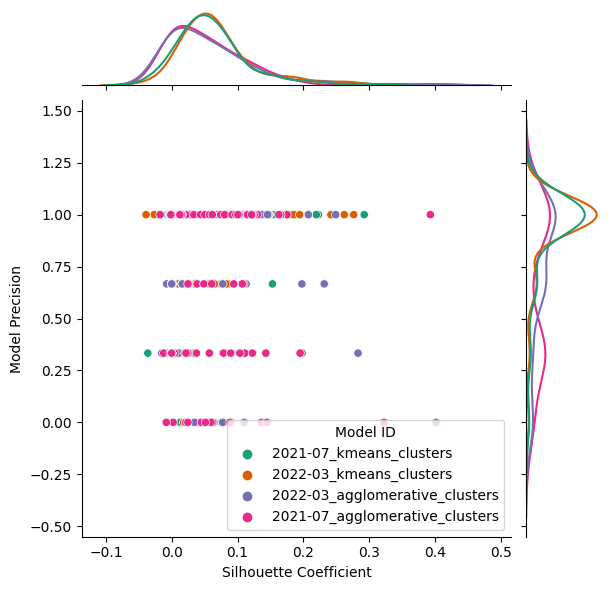

In [13]:
sns.jointplot(data=joined_df, x="Silhouette Coefficient", y="Model Precision", hue="Model ID", marginal_kws={"fill":False})

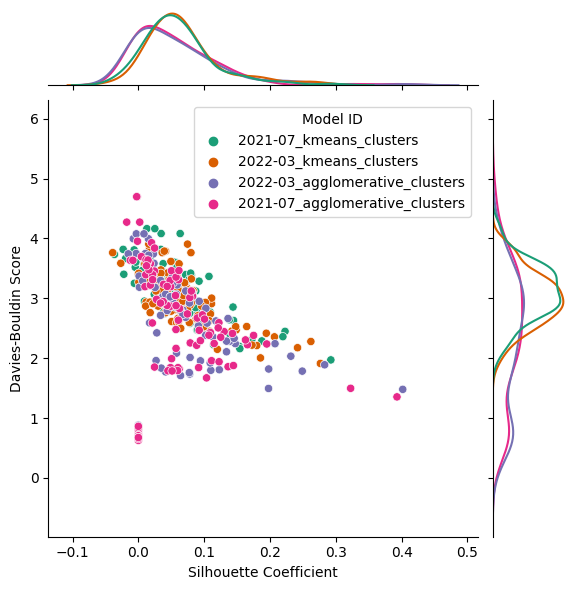

In [14]:
sns.jointplot(data=joined_df, x="Silhouette Coefficient", y="Davies-Bouldin Score", hue="Model ID", marginal_kws={"fill":False})

(-0.2, 0.5)

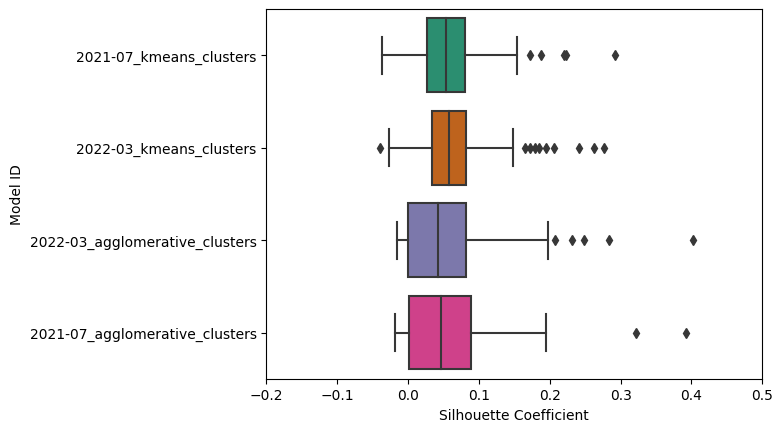

In [15]:
ax = sns.boxplot(data=joined_df, y="Model ID", x="Silhouette Coefficient")
ax.set_xlim(-0.2, 0.5)

(0.0, 5.0)

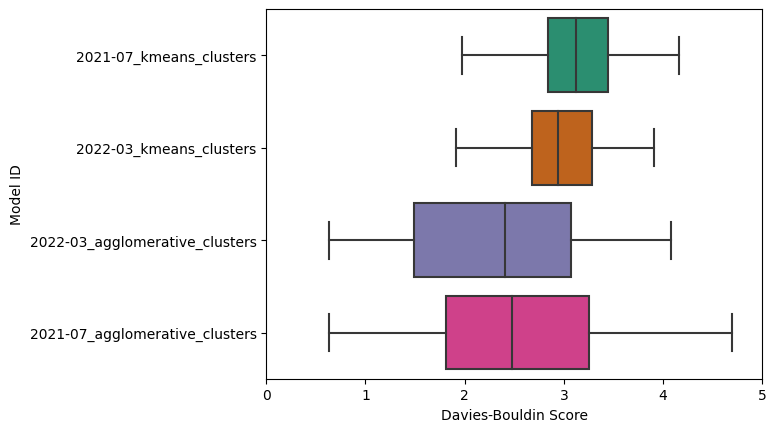

In [16]:
ax = sns.boxplot(data=joined_df, y="Model ID", x="Davies-Bouldin Score")
ax.set_xlim(0, 5)

[Text(0, 0, '0.0'), Text(1, 0, '0.33'), Text(2, 0, '0.66'), Text(3, 0, '1.0')]

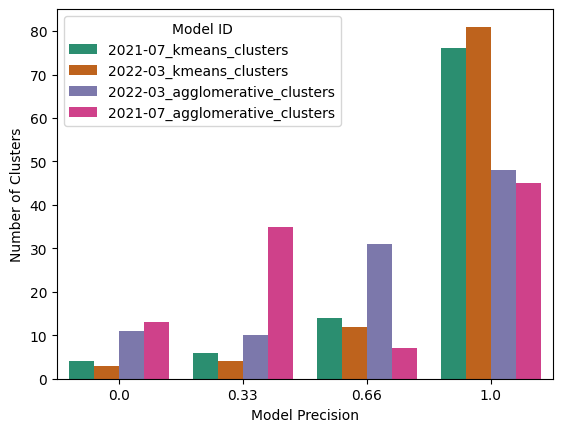

In [17]:
g = sns.countplot(data=joined_df, x="Model Precision", hue="Model ID")
g.set(ylabel="Number of Clusters")
g.set_xticklabels(["0.0", "0.33", "0.66", "1.0"])

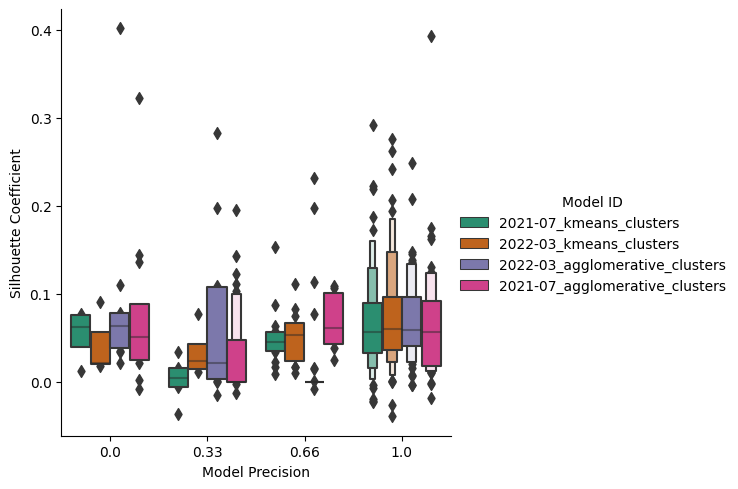

In [18]:
g = sns.catplot(data=joined_df, x="Model Precision", y="Silhouette Coefficient", hue="Model ID", kind="boxen")
g.set_xticklabels(["0.0", "0.33", "0.66", "1.0"])


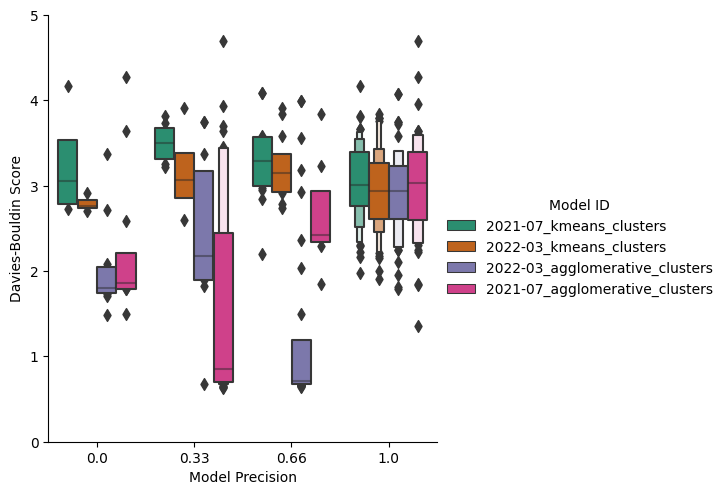

In [21]:
g = sns.catplot(data=joined_df, x="Model Precision", y="Davies-Bouldin Score", hue="Model ID", kind="boxen")
g.set_xticklabels(["0.0", "0.33", "0.66", "1.0"])
g.set(ylim=(0, 5))

In [ ]:
display(joined_df.sort_values(by=["Model Precision", "Silhouette Coefficient"], ascending=[False, False]))

,Model ID,Cluster ID,Ryan Coherence,Rebecca Coherence,Ethan Coherence,Coherence Score,Model Precision,cluster_id,Silhouette Coefficient,Davies-Bouldin Score,month,model_type
368,2021-07_agglomerative_clusters,68,1,1,1,3,1.0,68,0.392880,1.353475,2021-07,agglomerative
82,2021-07_kmeans_clusters,82,1,1,1,3,1.0,82,0.292419,1.971203,2021-07,kmeans
136,2022-03_kmeans_clusters,36,1,1,1,3,1.0,36,0.276500,1.911892,2022-03,kmeans
157,2022-03_kmeans_clusters,57,1,1,1,3,1.0,57,0.262068,2.278752,2022-03,kmeans
249,2022-03_agglomerative_clusters,49,1,1,1,3,1.0,49,0.249005,1.783742,2022-03,agglomerative
...,...,...,...,...,...,...,...,...,...,...,...,...
356,2021-07_agglomerative_clusters,56,0,0,0,0,0.0,56,0.021252,2.588317,2021-07,agglomerative
147,2022-03_kmeans_clusters,47,0,0,0,0,0.0,47,0.017949,2.761372,2022-03,kmeans
26,2021-07_kmeans_clusters,26,0,0,0,0,0.0,26,0.012932,4.163763,2021-07,kmeans
311,2021-07_agglomerative_clusters,11,0,0,0,0,0.0,11,0.002097,4.272668,2021-07,agglomerative


# Notes regarding example clusters
Low model precision, high Silhouette:
- 2022-03_agglomerative_clusters, cid 64: SubredditSummaryBot BotTown2 xrptrader WarehouseConsoleDeals strapon OzBargainNew
- 2021-07_agglomerative_clusters, cid 97: SubredditSummaryBot chicagor4r OzBargainNew DirtyRedditChat Mexico_Videos (note that this was a cluster where annotators also failed to identify the intruder)

High model precision, high Silhouette:
- 2021-07_agglomerative_clusters, cid 68: McDonaldsEmployees McLounge
- 2021-07_kmeans_clusters, cid 82 (Silhouette 0.292): Only Fans subreddits
- 2022-03_kmeans_clusters, cid 57 (Silhouette: 0.2765): German language subreddits 
